# SNN that detects Network bursts in a single channel
This notebook is a simple example of how to use a Spiking Neural Network (SNN) to detect network bursts in a single channel. 

## Definition of a network burst
A network burst is a sequence of spikes that occur in a short time window. The definition of a network burst is not unique and depends on the context. 

In this notebook, we will **consider a network burst any sequence of spikes that occurs within 10 ms**

### Check WD (change if necessary) and file loading

In [39]:
# Show current directory
import os
curr_dir = os.getcwd()
print(curr_dir)

# Check if the current WD is the file location
if "/src/network_bursts" not in os.getcwd():
    # Set working directory to this file location
    file_location = f"{os.getcwd()}/thesis-lava/src/network_bursts"
    print("File Location: ", file_location)

    # Change the current working Directory
    os.chdir(file_location)

    # New Working Directory
    print("New Working Directory: ", os.getcwd())

/home/monkin/Desktop/feup/thesis/thesis-lava/src/network_bursts


In [40]:
from lava.proc.lif.process import LIF, LIFRefractory
from lava.proc.dense.process import Dense

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

In [41]:
# Define the number of neurons in each LIF Layer
n1 = 251   # Let's create a simple program with only 1 LIF layer

In [42]:
import numpy as np

v_th = 1
v_init = 0
du = 0.4
dv = 0.05
use_refractory = True
refrac_period = 10

# Scale the weights
weights_scale = 0.3

# Simulation Parameters
init_offset = 0  # 1000                  
virtual_time_step_interval = 1  
num_steps = 3000    # 1000      # 3000  # 26500     # TODO: Check the number of steps to run the simulation for

# Input File
file_path =  "../lab_data/lab_data_all_channels.csv"   # "data/custom_activations_burst_1.csv"       # "../lab_data/lab_data_1-8channels.csv"

In [43]:
# Create Processes
lif1 = LIF(
    shape=(n1,),  # There are 2 neurons
    vth=v_th,  # TODO: Verify these initial values
    v=v_init,
    dv=dv,    # Inverse of decay time-constant for voltage decay
    du=du,  # Inverse of decay time-constant for current decay
    bias_mant=0,
    bias_exp=0,
    name="lif1"
)

refrac_lif1 = LIFRefractory(
    shape=(n1,),  # There are 2 neurons
    vth=v_th,  # TODO: Verify these initial values
    v=v_init,
    dv=dv,    # Inverse of decay time-constant for voltage decay
    du=du,  # Inverse of decay time-constant for current decay
    bias_mant=0,
    bias_exp=0,
    refractory_period=refrac_period,
    name="lif1"
)

### Choose the Selected LIF

In [44]:
selected_lif = refrac_lif1 if use_refractory else lif1

In [45]:
for proc in [selected_lif]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: lif1  Port Name: a_in  Size: 251
Proc: lif1  Port Name: s_out Size: 251


## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [46]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array
    TODO: Could try to use a structured array instead?

    Args:
        file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header='infer')
        # print(df.head())

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array. Each row is a spike event. The first column is the time and the second column is the channel idx
        spike_events = df.to_numpy()

        return spike_events
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

In [47]:
# Call the function to read the spike events
spike_events = read_spike_events(file_path)
print("Spike events: ", spike_events.shape, "\n", spike_events[:10])

Spike events:  (40020, 2) 
 [[ 99.5 229. ]
 [303.6   7. ]
 [502.5 229. ]
 [510.6  71. ]
 [528.   54. ]
 [540.9   7. ]
 [589.3 225. ]
 [631.6 100. ]
 [633.8 100. ]
 [758.3 229. ]]


In [48]:
# Find the max channel idx
max_channel_idx = int(np.max(spike_events[:, 1]))
print("Max Channel Idx: ", max_channel_idx)

Max Channel Idx:  251


## Generate the Ground Truth

In [49]:
from ground_truth import find_channel_bursts

# Generate the Ground Truth -> Find the channel bursts according to the conditions specified
CAUSALITY_WINDOW = refrac_period

# Parameters to Calculate Channel Bursts
num_spikes_to_burst = 2
max_burst_duration = CAUSALITY_WINDOW
min_inter_burst_interval = CAUSALITY_WINDOW
# Calculate the Channel Bursts
gt, gt_detailed = find_channel_bursts(spike_events, num_spikes_to_burst, max_burst_duration, min_inter_burst_interval, verbose=False)

print("Ground Truth: ", gt)
print("Ground Truth Detailed: ", gt_detailed)

Ground Truth:  {100.0: [633.8000000000001, 5004.1, 5019.7, 5028.2, 5884.0, 5901.3, 5906.8, 5922.5, 5927.7, 5943.7, 5948.7, 5965.8, 5972.6, 5988.400000000001, 5993.6, 6007.900000000001, 6024.0, 6029.5, 6052.2, 6128.2, 6169.900000000001, 6214.5, 6246.400000000001, 6371.1, 6409.8, 20756.8, 20761.2, 22061.0, 22079.0, 22089.1, 22093.9, 22159.1, 22174.2, 22179.2, 22198.5, 22204.2, 23476.9, 26736.5, 29595.3, 29612.9, 29618.0, 30810.5, 30828.7, 30836.2, 30852.6, 30862.0, 33396.0, 33413.4, 33418.3, 33433.7, 33448.8, 33453.7, 33471.9, 33477.0, 33492.5, 33502.2, 33656.3, 33691.5, 33730.9, 33755.2, 33784.0, 33954.5, 39233.4, 43146.9, 43164.6, 44373.8, 45160.8, 45177.5, 45194.7, 46755.8, 46792.8, 47416.6, 47434.3, 47443.3, 47454.2, 47471.1, 47476.2, 47503.9, 47522.1, 47526.9, 47544.1, 47548.9, 49903.2, 49919.4, 50225.4, 50243.2, 53131.9, 53511.0, 53530.8, 53925.6, 55141.4, 55157.4, 56967.2, 56982.0, 57195.8, 58719.1, 58738.6, 58745.0, 58763.4, 58769.3, 58787.3, 58792.7, 58812.2, 58817.3, 59007.2, 5

In [50]:
# Crop the ground truth according to the simulation time
gt_cropped = gt.copy()
for elec_idx in gt_cropped:
    gt_cropped[elec_idx] = [spike_time for spike_time in gt_cropped[elec_idx] if (
        spike_time >= init_offset and
        spike_time < init_offset + num_steps*virtual_time_step_interval
        )
    ]

print("Ground Truth Cropped: ", gt_cropped)

Ground Truth Cropped:  {100.0: [633.8000000000001], 195.0: [1424.0, 2789.7000000000003, 2869.5, 2882.6, 2888.2000000000003], 240.0: [1426.8, 2792.4, 2879.9, 2897.9], 230.0: [1427.4, 2792.6], 229.0: [1427.6, 2790.1, 2873.3, 2889.2000000000003, 2904.4], 189.0: [1429.2, 2791.3, 2878.4], 1.0: [1430.4, 2793.7000000000003, 2881.6, 2887.1, 2899.4], 150.0: [1430.5, 2791.0, 2887.6], 193.0: [1431.2, 2896.0], 89.0: [1511.4], 7.0: [2052.3], 171.0: [2796.9, 2887.3], 182.0: [2797.8, 2881.2000000000003], 45.0: [2808.0, 2901.5], 220.0: [2876.8, 2908.1], 175.0: [2884.8], 54.0: [2901.6, 2922.9], 71.0: [2902.3], 52.0: [2904.3, 2915.2000000000003], 49.0: [], 125.0: [], 87.0: [], 93.0: [], 65.0: [], 86.0: [], 107.0: [], 239.0: [], 164.0: [], 97.0: [], 46.0: [], 186.0: [], 103.0: [], 8.0: [], 83.0: [], 188.0: [], 4.0: [], 185.0: [], 81.0: [], 41.0: [], 98.0: [], 59.0: [], 92.0: [], 78.0: [], 84.0: [], 42.0: [], 226.0: [], 202.0: [], 60.0: [], 104.0: [], 58.0: [], 56.0: [], 219.0: [], 38.0: [], 197.0: [], 18

### Define the SpikeEvent Generator Interface

In [51]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        shape (tuple): Shape of the output port
        file_name (str): Name of the file containing the spike events
    """
    def __init__(self, shape: tuple, spike_events: np.ndarray, name: str) -> None:
        super().__init__(name=name)
        self.s_out = OutPort(shape=shape)
        self.spike_events = Var(shape=spike_events.shape, init=spike_events)

### Map the input channels to the corresponding indexes in the input layer
Since the input channels in the input file may be of any number, we need to map the input channels to the corresponding indexes in the input layer. This is done by the `channel_map` dictionary.

In [52]:
# Map the channels of the input file to the respective index in the output list of SpikeEventGen
# channel_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}

# Create a channel map based on the max channel idx
channel_map = {channel: idx for idx, channel in enumerate(range(1, max_channel_idx+1))}
print("Channel Map: ", channel_map)
print("Number of channels: ", len(channel_map))

Channel Map:  {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121

### Implement the `SpikeEventGenerator` Model

In [53]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)   # TODO: Check if we should keep it as a numpy array, or transform it to a list

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        # print("spike events", self.spike_events.__str__())    # TODO: Check why during initialization the variable prints the class, while during run it prints the value
        self.curr_spike_idx = 0     # Index of the next spiking event to send
        self.virtual_time_step_interval = virtual_time_step_interval  # 1000    # Arbitrary time between time steps (in microseconds). This is not a real time interval (1000ms = 1s)
        self.init_offset = init_offset        # 698995               # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        # Use random spikes to test it
        # spike_data[0] = np.random.random()  # Only 1 neuron is sending data (spikes)
        # self.curr_spike_idx += 1

        # Use the spike events from the file
        # print("spike events: ", self.spike_events[:5])
        # TODO: For now we are using the time_step as the time measurement that will simulate real-time activity. It would be better to have access to the running time
        
        #print("time step:", self.time_step)
        # If the current simulation time is greater than the next spike event, send a spike
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval

        spiking_channels = set()   # List of channels that will spike at the same time
        while (self.curr_spike_idx < len(self.spike_events)) and currTime >= self.spike_events[self.curr_spike_idx][0]:  # Check if there are more than 1 spike events to send
            if self.spike_events[self.curr_spike_idx][0] < self.init_offset:
                self.curr_spike_idx += 1
                continue
            
            curr_channel = self.spike_events[self.curr_spike_idx][1]

            # Check if the next spike belongs to a channel that will already spike at the same time
            if curr_channel in spiking_channels:    # If the channel is already spiking, we stop the spikes for this time step
                break

            # Add the channel to the list of spiking channels
            spiking_channels.add(curr_channel)

            # Send a spike
            out_idx = channel_map[curr_channel]     # Map the channel to the output index
            if out_idx < self.s_out.shape[0]:   # Check if the channel is valid
                spike_data[out_idx] = 1.0   # Send a spike  (value corresponds to the punctual current of the spike event)

            # Move to the next spike event
            self.curr_spike_idx += 1

        # if len(spiking_channels) > 0:   # Print the spike event if there are any spikes
        #     print(f"sending spike event at time: {currTime}({self.time_step}) last spike idx: {self.curr_spike_idx-1} spike time: {self.spike_events[self.curr_spike_idx-1][0]}")

        # Send spikes
        # print("sending spike_data: ", spike_data, " at step: ", self.time_step)
        self.s_out.send(spike_data)

        # Stop the Process if there are no more spike events to send. (It will stop all the connected processes)
        # TODO: Should it be another process that stops the simulation? Such as the last LIF process
        # if self.curr_spike_idx >= 5: # len(self.spike_events):
        #    self.pause()


## Connect the Custom Input Layer to the middle layer

To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we use another `Dense` Layer.

In [54]:
# Create the Input Process
spike_event_gen = SpikeEventGen(shape=(n1,), spike_events=spike_events, name="CustomInput")

# Define the matrix of weights
dense_weights = np.eye(n1)

# dense_weights = np.round(dense_weights * weights_scale).astype(np.int32)
dense_weights = dense_weights * weights_scale

# Instantiante a Dense Layer to connect the SpikeEventGen to the middle layer
dense_input = Dense(weights=dense_weights, name="DenseInput")     # 1-1 connectivity with the Middle Layer (should be a 2x2 matrix right now)

# If I connect the SpikeEventGen to the Dense Layer, the a_out value of the custom input will be rounded to 0 or 1 in the Dense Layer (it will not be a float) 
# Connect the SpikeEventGen to the Dense Layer
spike_event_gen.s_out.connect(dense_input.s_in)

# Connect the Dense_Input to the LIF1 Layer
dense_input.a_out.connect(selected_lif.a_in)

# Connect the SpikeEventGen layer directly to the LIF1 layer
# spike_event_gen.s_out.connect(lif1.a_in)

### Take a look at the connections in the Input Layer

In [55]:
for proc in [spike_event_gen, dense_input, selected_lif]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: CustomInput Port Name: s_out Size: 251
Proc: DenseInput Port Name: s_in  Size: 251
Proc: DenseInput Port Name: a_out Size: 251
Proc: lif1  Port Name: a_in  Size: 251
Proc: lif1  Port Name: s_out Size: 251


In [56]:
# Weights of the Input Dense Layer
dense_input.weights.get()

array([[0.3, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.3, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.3, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.3, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.3, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.3]])

### Record Internal Vars over time
To record the evolution of the internal variables over time, we need a `Monitor`. For this example, we want to record the membrane potential of the `LIF` Layer, hence we need 1 `Monitors`.

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function

In [57]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(selected_lif.v, num_steps)
monitor_lif1_u.probe(selected_lif.u, num_steps)

## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [58]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

### Execute

In [59]:
selected_lif.run(condition=run_condition, run_cfg=run_cfg)

### Retrieve recorded data

In [60]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["lif1"]["u"] = data_lif1_u["lif1"]["u"]   # Merge the dictionaries to contain both voltage and current


In [61]:
data_lif1

{'lif1': {'v': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [9.05276516e-05, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.60012691e-05, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.17012056e-05, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  'u': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000

In [62]:
# Check the shape to verify if it is printing the voltage for every step
len(data_lif1['lif1']['v'])     # Indeed, there are 300 values (same as the number of steps we ran the simulation for)

3000

### Plot the recorded data

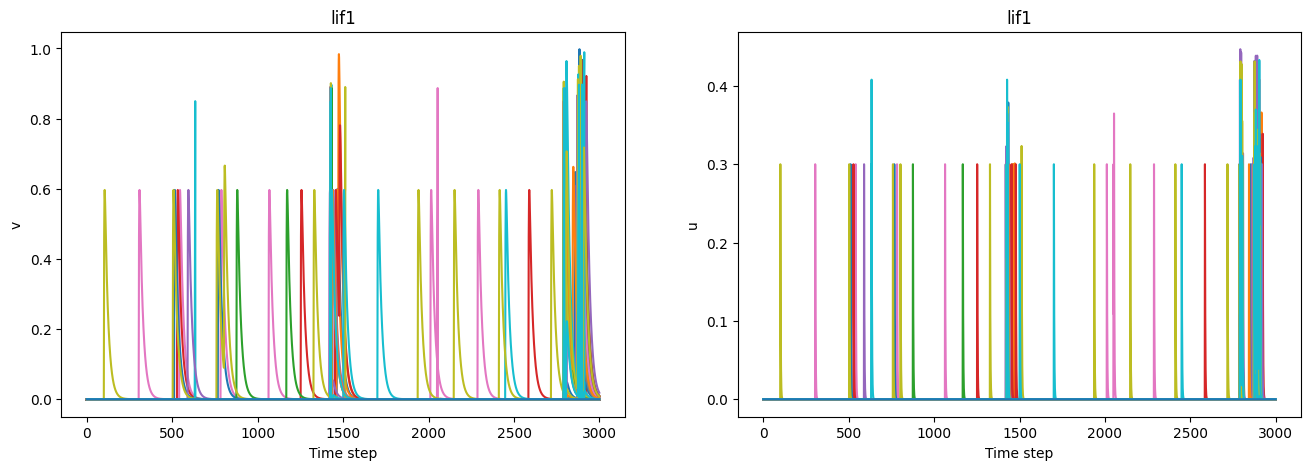

In [63]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(122)
ax1.set_title('Current (U) / time step')

# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)


## Find the timesteps where the channel bursts occur

In [64]:
from utils.data_analysis import find_spike_times

# Call the find_spike_times util function that detects the spikes in a voltage array
spike_times_lif1 = find_spike_times(data_lif1['lif1']['v'], data_lif1['lif1']['u'])

# Add the initial offset to the spike times (1st index )
for spike_times in spike_times_lif1:
    spike_times[0] += init_offset
    
print("Spike times: ", spike_times_lif1)

Spike times:  [[ 635   99]
 [1425  194]
 [1428  239]
 [1429  228]
 [1429  229]
 [1431  188]
 [1432    0]
 [1432  149]
 [1433  192]
 [1513   88]
 [2054    6]
 [2791  194]
 [2792  149]
 [2792  228]
 [2793  188]
 [2794  229]
 [2794  239]
 [2795    0]
 [2798  170]
 [2799  181]
 [2809   44]
 [2871  194]
 [2875  228]
 [2878  219]
 [2881  188]
 [2881  239]
 [2883  181]
 [2884    0]
 [2885  194]
 [2886  174]
 [2889  149]
 [2889  170]
 [2891  228]
 [2896  192]
 [2899  239]
 [2901    0]
 [2902   44]
 [2902   53]
 [2904   70]
 [2906   51]
 [2912  219]
 [2924   53]]


## View the Voltage and Current dynamics with an interactive plot

Grab the data from the recorded variables

In [65]:
lif1_voltage_vals = data_lif1['lif1']['v']
lif1_current_vals = data_lif1['lif1']['u']

print("v_ch0 shape:", len(lif1_voltage_vals))

# print("voltage head: ", lif1_voltage_vals[:10])

v_ch0 shape: 3000


## Bokeh Function to create a figure

In [66]:
# Interactive Plot for the voltage and current
# bokeh docs: https://docs.bokeh.org/en/2.4.1/docs/first_steps/first_steps_1.html
import bokeh.plotting as bplt
from bokeh.io import curdoc
from bokeh.models import BoxAnnotation
from math import ceil

# Apply the theme to the plot
curdoc().theme = "caliber"  # Can be one of "caliber", "dark_minimal", "light_minimal", "night_sky", "contrast"

# colors list
line_colors = ["green", "blue", "red", "orange", "purple", "black", "cyan", "pink", "brown", "mediumaquamarine", "teal", "olive", "darkgreen", 
               "mediumslateblue", "lightsalmon", "gold", "indigo", "aqua", "rosybrown", "chocolate"]  # TODO: Add more colors if needed

""" Only possible in python>= 3.12 
type BoxAnnotationParams = {
    "bottom": float,
    "top": float,
    "left": float,
    "right": float,
    "fill_alpha": float,
    "fill_color": str
} """

"""
create_fig: Create a figure with the given parameters

Args:
    title (str): Title of the plot
    x_axis_label (str): Label of the x-axis
    y_axis_label (str): Label of the y-axis
    x (np.ndarray): Array of x values
    y_arrays (list): List of tuples containing the y values and the legend label
    x_range (tuple): Range of the x-axis    (Can make linked ranges with other plots)
    y_range (tuple): Range of the y-axis
    sizing_mode (str): Sizing mode of the plot
    tools (str): Tools to be added to the plot
    tooltips (str): Tooltips to be added to the plot
    legend_location (str): Location of the legend
    legend_bg_fill_color (str): Background fill color of the legend
    legend_bg_fill_alpha (float): Background fill alpha of the legend
    box_annotation_params (dict): Parameters to create a box annotation
Returns:
    bplt.Figure: The plot
"""
def create_fig(title, x_axis_label, y_axis_label, 
               x, y_arrays, x_range=None, y_range=None,
               sizing_mode=None, tools=None, tooltips=None, 
               legend_location=None, legend_bg_fill_color=None, legend_bg_fill_alpha=None, 
               box_annotation_params=None):
    # Create the plot
    p = bplt.figure(
        title=title,
        x_axis_label=x_axis_label, 
        y_axis_label=y_axis_label,
        sizing_mode=sizing_mode or "stretch_both",    # Make the plot stretch in both width and height
        tools=tools or "pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
        tooltips=tooltips or "Data point @x: @y"
    )

    # Set the range of the x and y-axis
    if x_range is not None:
        p.x_range = x_range
    if y_range is not None:
        p.y_range = y_range

    # Add a line graph to the plot for each y_array
    for (arr_idx, y_array) in enumerate(y_arrays):
        p.line(x, y_array[0], legend_label=y_array[1], line_width=2, line_color=line_colors[arr_idx % len(line_colors)])

    # Legend settings
    p.legend.location = legend_location or "top_right"
    p.legend.background_fill_color = legend_bg_fill_color or "navy"
    p.legend.background_fill_alpha = legend_bg_fill_alpha or 0.1
    p.legend.click_policy = "hide"  # Clicking on a legend item will hide the corresponding line
    # Format legend to 2 columns
    p.legend.ncols = ceil(len(y_arrays) / 7)    # Make the number of rows no more than 7

    # Grid settings
    # p.ygrid.grid_line_color = "red"

    # Add a box annotation
    if box_annotation_params is not None:
        inner_box = BoxAnnotation(
            bottom=box_annotation_params["bottom"], 
            top=box_annotation_params["top"], 
            left=box_annotation_params["left"], 
            right= box_annotation_params["right"], 
            fill_alpha=box_annotation_params["fill_alpha"], 
            fill_color=box_annotation_params["fill_color"]
        )
        p.add_layout(inner_box)

    # Return the plot
    return p

## Assemble the values to be plotted

In [67]:
# Define the x and y values
x = [init_offset + val for val in range(num_steps)]

v_y1 = [val[0] for val in lif1_voltage_vals]
v_y2 = [val[1] for val in lif1_voltage_vals]
v_y3 = [val[2] for val in lif1_voltage_vals]
v_y4 = [val[3] for val in lif1_voltage_vals]
v_y5 = [val[4] for val in lif1_voltage_vals]
v_y6 = [val[5] for val in lif1_voltage_vals]
v_y7 = [val[6] for val in lif1_voltage_vals]
v_y8 = [val[7] for val in lif1_voltage_vals]

# Create the plot
voltage_lif1_y_arrays = [(v_y1, "Ch. 1"), (v_y2, "Ch. 2"), (v_y3, "Ch. 3"), (v_y4, "Ch. 4"), 
                         (v_y5, "Ch. 5"), (v_y6, "Ch. 6"), (v_y7, "Ch. 7"), (v_y8, "Ch. 8")]    # List of tuples containing the y values and the legend label
# Define the box annotation parameters
box_annotation_voltage = {
    "bottom": 0,
    "top": v_th,
    "left": 0,
    "right": num_steps,
    "fill_alpha": 0.03,
    "fill_color": "green"
}

# Create the LIF1 Voltage
voltage_lif1_plot = create_fig(
    title="LIF1 Voltage dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Voltage (V)',
    x=x, 
    y_arrays=voltage_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    box_annotation_params=box_annotation_voltage
)


# Create the LIF1 Current
u_y1 = [val[0] for val in lif1_current_vals]
u_y2 = [val[1] for val in lif1_current_vals]
u_y3 = [val[2] for val in lif1_current_vals]
u_y4 = [val[3] for val in lif1_current_vals]
u_y5 = [val[4] for val in lif1_current_vals]
u_y6 = [val[5] for val in lif1_current_vals]
u_y7 = [val[6] for val in lif1_current_vals]
u_y8 = [val[7] for val in lif1_current_vals]
current_lif1_y_arrays = [(u_y1, "Ch. 1"), (u_y2, "Ch. 2"), (u_y3, "Ch. 3"), (u_y4, "Ch. 4"),
                         (u_y5, "Ch. 5"), (u_y6, "Ch. 6"), (u_y7, "Ch. 7"), (u_y8, "Ch. 8")]    # List of tuples containing the y values and the legend label
current_lif1_plot = create_fig(
    title="LIF1 Current dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Current (U)',
    x=x, 
    y_arrays=current_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    x_range=voltage_lif1_plot.x_range,    # Link the x-axis range to the voltage plot
)

# bplt.show(voltage_lif1_plot)

## Show the Plots assembled in a grid

In [68]:
from bokeh.layouts import gridplot

# Create array of plots to be shown
plots = [voltage_lif1_plot, current_lif1_plot]

if len(plots) == 1:
    grid = plots[0]
else:   # Create a grid layout
    grid = gridplot(plots, ncols=2, sizing_mode="stretch_both")

# Show the plot
bplt.show(grid)

## Export the plot to a file

In [87]:
export = False

OUT_FOLDER = "./results/channel_burst"
OUT_FILENAME = f"lab_ch1-{n1}_2spikes_10ms_{v_th}_{du}_{dv}_{refrac_period}_{weights_scale}"

if export:
    file_path = f"{OUT_FOLDER}/{OUT_FILENAME}.html"

    # Customize the output file settings
    bplt.output_file(filename=file_path, title="Channel Burst detection - LIF1 Voltage and Current dynamics")

    # Save the plot
    bplt.save(grid)

## Calculate Detection Metrics

### Convert the spike times to the same format as the Ground Truth

In [88]:
# Invert the mapping of the electrodes to the neuron indices
channel_map_inv = {v: k for k, v in channel_map.items()}
print("Channel Map Inverted: ", channel_map_inv)

Channel Map Inverted:  {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96, 96: 97, 97: 98, 98: 99, 99: 100, 100: 101, 101: 102, 102: 103, 103: 104, 104: 105, 105: 106, 106: 107, 107: 108, 108: 109, 109: 110, 110: 111, 111: 112, 112: 113, 113: 114, 114: 115, 115: 116, 116: 117, 117: 118, 118: 119, 119:

In [89]:
predicted_spikes = {}
for (spike_time, neuron_idx) in spike_times_lif1:
    print(f"spike time: {spike_time} neuron idx: {neuron_idx}")

    # Map the neuron index to the electrode channel index
    electrode_idx = channel_map_inv[neuron_idx]

    # Add the spike time to the predicted spikes
    curr_ch_spikes = predicted_spikes.get(electrode_idx, [])
    curr_ch_spikes.append(spike_time)
    predicted_spikes[electrode_idx] = curr_ch_spikes

print("Predicted Spikes: ", predicted_spikes)

spike time: 635 neuron idx: 99
spike time: 1425 neuron idx: 194
spike time: 1428 neuron idx: 239
spike time: 1429 neuron idx: 228
spike time: 1429 neuron idx: 229
spike time: 1431 neuron idx: 188
spike time: 1432 neuron idx: 0
spike time: 1432 neuron idx: 149
spike time: 1433 neuron idx: 192
spike time: 1513 neuron idx: 88
spike time: 2054 neuron idx: 6
spike time: 2791 neuron idx: 194
spike time: 2792 neuron idx: 149
spike time: 2792 neuron idx: 228
spike time: 2793 neuron idx: 188
spike time: 2794 neuron idx: 229
spike time: 2794 neuron idx: 239
spike time: 2795 neuron idx: 0
spike time: 2798 neuron idx: 170
spike time: 2799 neuron idx: 181
spike time: 2809 neuron idx: 44
spike time: 2871 neuron idx: 194
spike time: 2875 neuron idx: 228
spike time: 2878 neuron idx: 219
spike time: 2881 neuron idx: 188
spike time: 2881 neuron idx: 239
spike time: 2883 neuron idx: 181
spike time: 2884 neuron idx: 0
spike time: 2885 neuron idx: 194
spike time: 2886 neuron idx: 174
spike time: 2889 neuro

### Calculate the Confusion Matrix

In [90]:
# Initialize the variables that store the values of the Confusion Matrix
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

In [91]:
# Go through the ground truth and check if the predicted spikes are correct
# TODO: For now using I'm considering the causality window [gt_burst_time - CAUSALITY_WINDOW, gt_burst_time + CAUSALITY_WINDOW]. 
for electrode_idx in gt_cropped:
    # Get the ground truth burst times for the current electrode
    gt_burst_times = gt_cropped[electrode_idx]

    # Get the predicted burst times for the current electrode
    pred_burst_times = predicted_spikes.get(electrode_idx, [])

    # Check if the predicted spikes are correct
    for gt_burst_time in gt_burst_times:
        # Check if the predicted burst time is within the causality window [gt_burst_time, gt_burst_time + CAUSALITY_WINDOW]
        if any([abs(pred_burst_time - gt_burst_time) <= CAUSALITY_WINDOW for pred_burst_time in pred_burst_times]):
            true_positive += 1
        else:
            false_negative += 1

    # Check if the predicted spikes are false positives
    for pred_burst_time in pred_burst_times:
        # Check if the predicted burst time is within the causality window [gt_burst_time, gt_burst_time + CAUSALITY_WINDOW]
        if all([abs(pred_burst_time - gt_burst_time) > CAUSALITY_WINDOW for gt_burst_time in gt_burst_times]):
            false_positive += 1

# Calculate the True Negative value
# TN = P - (TP + FP + FN)
true_negative = num_steps - true_positive - false_positive - false_negative

In [92]:
# Print the Confusion Matrix
print("True Positive: ", true_positive)
print("False Positive: ", false_positive)
print("True Negative: ", true_negative)
print("False Negative: ", false_negative)

# Print the Total of predictions
total_predictions = true_positive + false_positive + true_negative + false_negative
print("Total Predictions: ", total_predictions)

True Positive:  45
False Positive:  0
True Negative:  2954
False Negative:  1
Total Predictions:  3000


### Calculate Prediction Metrics

In [93]:
# Calculate relevant metrics
if true_positive + false_positive == 0:
    print("No relevant predictions were made. Cannot calculate metrics.")
    exit()

accuracy = (true_positive + true_negative) / total_predictions * 100    # Proportion of correct predictions
precision = true_positive / (true_positive + false_positive) * 100      # Proportion of TPs that were identified correctly
recall = true_positive / (true_positive + false_negative) * 100         # Proportion of TPs that were captured by the model
f1_score = (2 * precision * recall) / (precision + recall)              # Harmonic mean of Precision and Recall
specificity = true_negative / (true_negative + false_positive) * 100    # Proportion of TNs that were identified correctly

print(f"Accuracy: {accuracy}%")
print(f"Precision: {precision}%")
print(f"Recall: {recall}%")
print(f"F1 Score: {f1_score}")
print(f"Specificity: {specificity}%")

Accuracy: 99.96666666666667%
Precision: 100.0%
Recall: 97.82608695652173%
F1 Score: 98.90109890109889
Specificity: 100.0%


# Export the results of the Detection to a JSON file
Export the results of the classification to a JSON file. This file will include:
- `Causality Window` used
- Classification Metrics (`True Positives`, `False Positives`, `True Negatives`, `False Negatives`, `Accuracy`, `Precision`, `Recall`, `F1 Score`, `Specificity`)

In [94]:
import json

# Export the results to a JSON file

# Create a dictionary with the results
json_results = {
    "causality_window": CAUSALITY_WINDOW,
    "metrics": {
        "true_positive": true_positive,
        "false_positive": false_positive,
        "true_negative": true_negative,
        "false_negative": false_negative,
        "total_predictions": total_predictions,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "specificity": specificity
    }
}

EXPORT_JSON_FILE = True
if EXPORT_JSON_FILE:
    json_file_name = f"{OUT_FOLDER}/{OUT_FILENAME}_metrics.json"
    with open(json_file_name, 'w') as f:
        json.dump(json_results, f)

## Stop the Runtime

In [95]:
selected_lif.stop()